In [1]:
# This notebook will demonstrate Bandits and Exploration/Exploitation
# It will show the trade-off exploration VS exploitation
# Fundamentals of Reinforcement Learning by University of Alberta & Alberta Machine Intelligence Institute, https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home/welcome accessed on July 2, 2021.
# Textbook : Richard S. Sutton and Andrew G. Barto, Reinforcement Learning: An Introduction, second edition, The MIT Press Cambridge, Massachusetts, London, England

In [2]:
# Section 0: Preliminaries
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('/Users/Luciano/anaconda3/pkgs')
from tqdm import tqdm
from RLGlue.rl_glue import RLGlue
import main_agent
# we import ten_arm_env. This is the 10-armed Testbed introduced in section 2.3 of the textbook.
import ten_arm_env
import test_env

In [3]:
# We create an agent that will find the action with the highest expected reward.
def argmax(q_values):
    top_value = float("-inf")
    ties = []
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        if q_values[i] > top_value:
            ties = []
            top_value = q_values[i]
        # if a value is equal to top value add the index to ties
        if q_values[i] == top_value:
            ties.append(i)
        # return a random selection from ties.
    return np.random.choice(ties)

In [4]:
# Section 1: Greedy Agent
# We create an agent that will find the action with the highest expected reward. 
# One way an agent could operate is to always choose the action with the highest value based on the agent’s current estimates. 
# This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. 
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        ### Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        #######################
        # Update Q values Hint: Look at the algorithm in section 2.4 of the textbook.
        # increment the counter in self.arm_count for the action from the previous time step
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1 
        # update the step size using self.arm_count
        step_size = 1 / self.arm_count[self.last_action]
        # update self.q_values for the action from the previous time step
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size*(reward - self.q_values[self.last_action])        
        # current action = ? # Use the argmax function you created above
        current_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.34it/s]


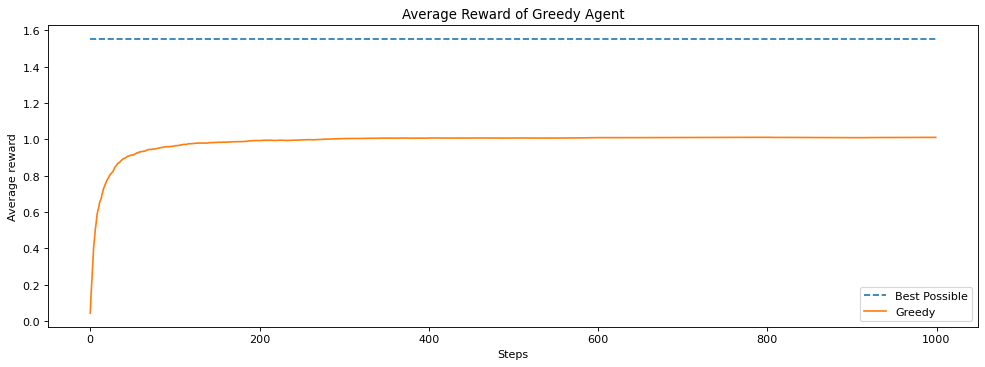

In [5]:
# Average reward obtained by greedy agent VS best reward
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.
all_averages = []

average_best = 0

for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

In [6]:
# We define now an epsilon Greedy agent to enable exploration
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        ##############################
        # increment the counter in self.arm_count for the action from the previous time step
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1
        # Update Q values - this should be the same update as your greedy agent above
        step_size = 1 / self.arm_count[self.last_action]
        # update self.q_values for the action from the previous time step
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size*(reward - self.q_values[self.last_action])
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # (hint: look at np.random.random()). If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.
        num = np.random.random()
        if num < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.16it/s]


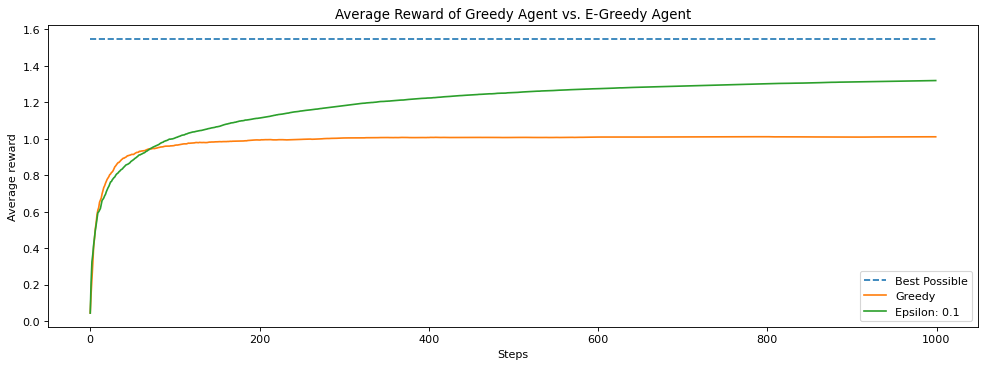

In [7]:
# compare Epsilon greedy results and Greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()
    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

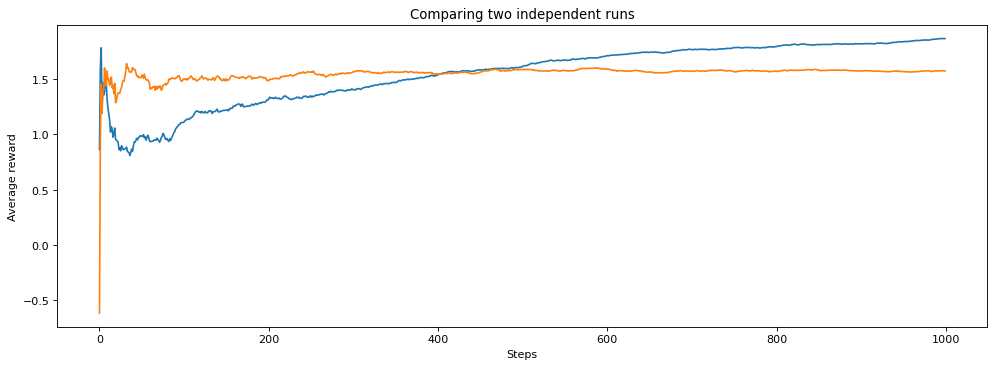

In [8]:
# Plot runs of e-greedy agent of two independent runs
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000
for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [9]:
# compare two random seeds
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
print()
print()
print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 56.72it/s]


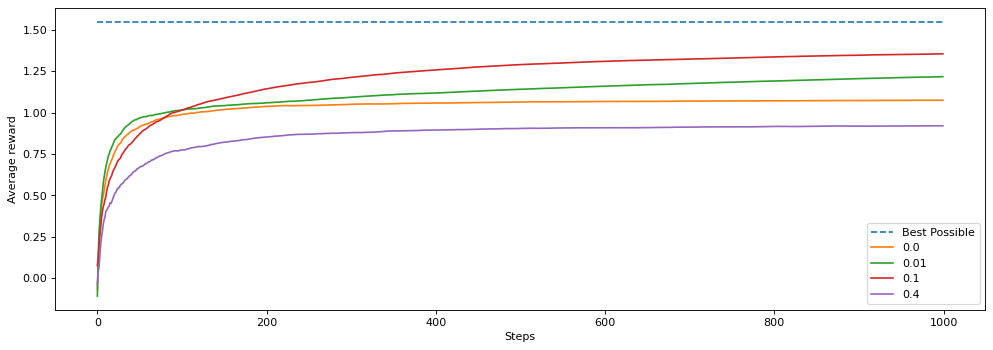

In [10]:
# Section 3: Comparing values of epsilon
# We try several different values for epsilon and see how they perform. 
# We try different settings of key performance parameters to understand how the agent might perform under different conditions.

# Below we run an experiment where we sweep over different values for epsilon:
# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
n_q_values = []
n_averages = []
n_best_actions = []
num_runs = 200
for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()  
        best_arm = np.argmax(rl_glue.environment.arms)
        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [11]:
# Section 4: The Effect of Step Size
# In Section 1 of this notebook, we decayed the step size over time based on action-selection counts. 
# The step-size was 1/N(A), where N(A) is the number of times action A was selected. 
# This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. 
# What would be the effect of doing that? And is it better to use a constant or the sample average method?
# To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : An int of the action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        self.q_values[self.last_action] = self.q_values[self.last_action] + self.step_size*(reward - self.q_values[self.last_action])
        # Choose action using epsilon greedy. This is the same as you implemented above.
        current_action = argmax(self.q_values)
        self.last_action = current_action
        return current_action

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.07it/s]
<ipython-input-12-b53aa19a212f>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


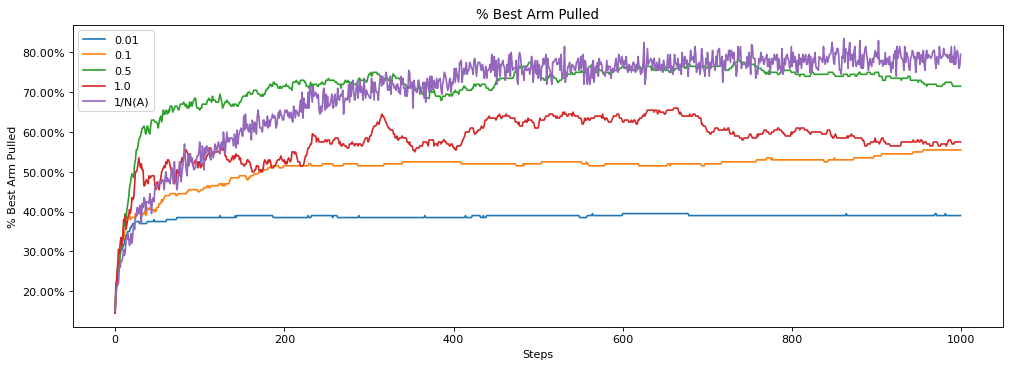

In [12]:
# Experiment code for different step sizes
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']
epsilon = 0.1
num_steps = 1000
num_runs = 200
fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}
for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()        
        best_arm = np.argmax(rl_glue.environment.arms)
        scores = [0]
        averages = []
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

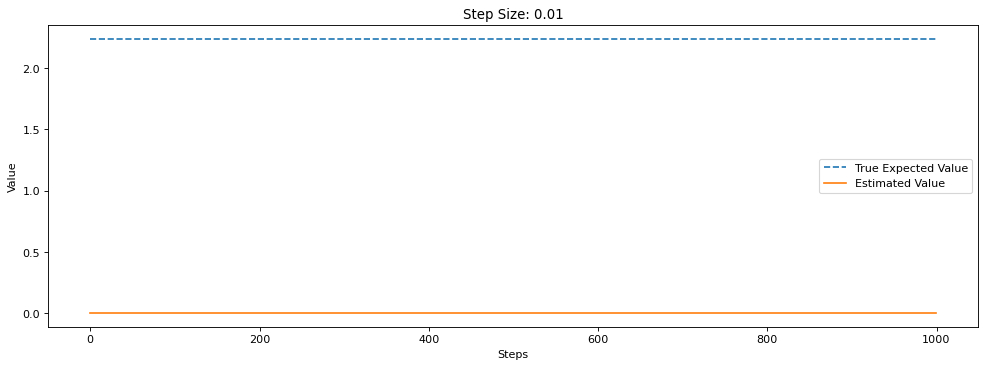

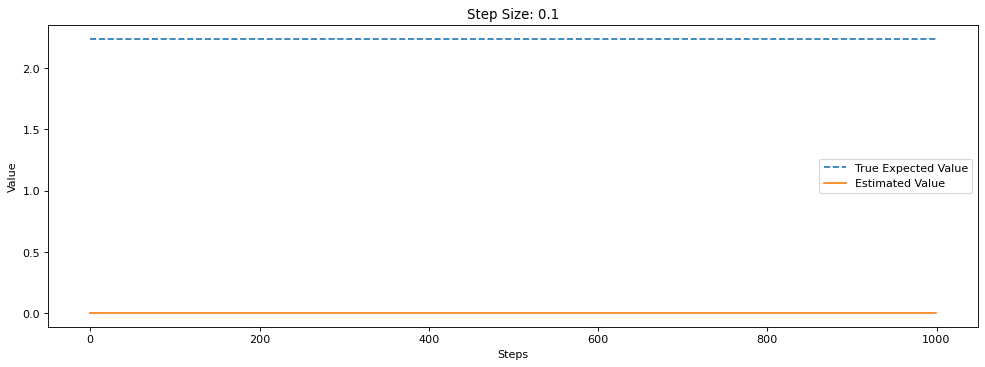

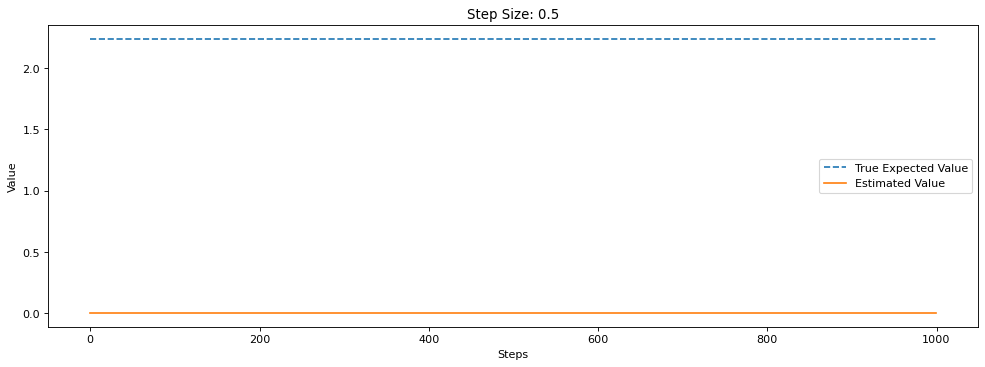

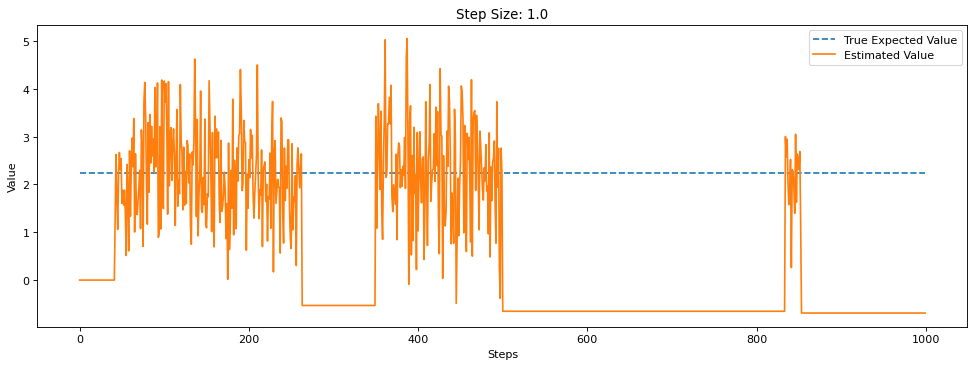

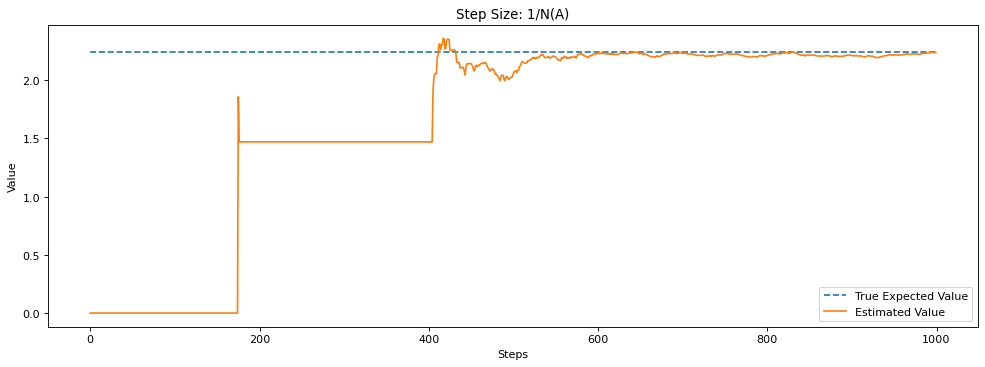

In [13]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.51it/s]


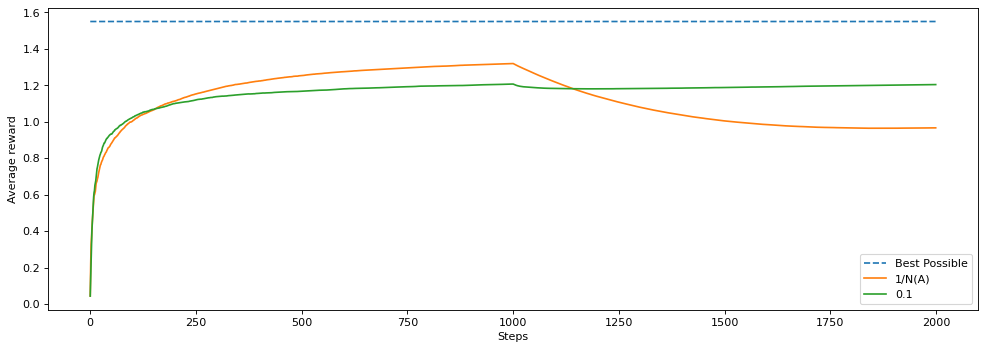

In [14]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()